In [1]:
!pip install kaggle --quiet

from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d vikramtiwari/pix2pix-dataset
!unzip -q pix2pix-dataset.zip -d pix2pix_data

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/vikramtiwari/pix2pix-dataset
License(s): unknown
 99% 2.38G/2.40G [00:19<00:00, 249MB/s]
100% 2.40G/2.40G [00:19<00:00, 133MB/s]


# Install dependencies


In [20]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.datasets as datasets
from torchvision.utils import save_image
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm

# Discriminator


In [3]:
class Discriminator(nn.Module):
  def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
    super(Discriminator, self).__init__()

    self.dis = nn.Sequential(
        nn.Conv2d(in_channels*2, features[0], kernel_size=4, stride=2, bias=False, padding_mode='reflect'),
        nn.LeakyReLU(0.2),
    )

    layers = []
    in_channels = features[0]

    for feature in features[1:]:
      self.dis.append(
          self._CNN_Block(in_channels, feature, stride=1 if feature == features[-1] else 2)
      )
      in_channels = feature

    self.dis.append(
        nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect'))

  # CNN Module
  def _CNN_Block(self, in_channels, out_channels, stride=2):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, bias=False, padding_mode='reflect'),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

  def forward(self, x, y):
    x = torch.cat([x, y], dim=1)

    return self.dis(x)

# Test Discriminator Module

In [4]:
def test_dis():
  x = torch.randn((1, 3, 256, 256))
  y = torch.randn((1, 3, 256, 256))

  model = Discriminator(in_channels=3)
  preds = model(x, y)
  print(preds.shape)

test_dis()

torch.Size([1, 1, 26, 26])


# Generator


In [5]:
class Generator(nn.Module):
  def __init__(self, in_channels=3, features=64):
    super(Generator, self).__init__()

    self.init_gen = nn.Sequential(
        nn.Conv2d(in_channels, features, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
        nn.LeakyReLU(0.2),
    )

    self.down_block1 = self._Block(features, features*2, down=True, act='leaky', use_dropout=False)
    self.down_block2 = self._Block(features*2, features*4, down=True, act='leaky', use_dropout=False)
    self.down_block3 = self._Block(features*4, features*8, down=True, act='leaky', use_dropout=False)
    self.down_block4 = self._Block(features*8, features*8, down=True, act='leaky', use_dropout=False)
    self.down_block5 = self._Block(features*8, features*8, down=True, act='leaky', use_dropout=False)
    self.down_block6 = self._Block(features*8, features*8, down=True, act='leaky', use_dropout=False)
    self.bottleneck = nn.Sequential(
        nn.Conv2d(features*8, features*8, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
        nn.ReLU()
    )
    self.up_block1 = self._Block(features*8, features*8, down=False, act='relu', use_dropout=True)
    self.up_block2 = self._Block(features*8 * 2, features*8, down=False, act='relu', use_dropout=True)
    self.up_block3 = self._Block(features*8 * 2, features*8, down=False, act='relu', use_dropout=True)
    self.up_block4 = self._Block(features*8 * 2, features*8, down=False, act='relu', use_dropout=True)
    self.up_block5 = self._Block(features*8 * 2, features*4, down=False, act='relu', use_dropout=True)
    self.up_block6 = self._Block(features*4 * 2, features*2, down=False, act='relu', use_dropout=True)
    self.up_block7 = self._Block(features*2 * 2, features, down=False, act='relu', use_dropout=True)
    self.final_up = nn.Sequential(
        nn.ConvTranspose2d(features*2, in_channels, kernel_size=4, stride=2, padding=1),
        nn.Tanh()
    )

  def _Block(self, in_channels, out_channels, down=True, act='relu', use_dropout=False):
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False, padding_mode='reflect') if down else nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)
    batch_norm = nn.BatchNorm2d(out_channels)
    activation = nn.ReLU() if act == 'relu' else nn.LeakyReLU(0.2)

    layers = [conv_layer, batch_norm, activation]
    if use_dropout:
        layers.append(nn.Dropout(0.5))

    return nn.Sequential(*layers)


  def forward(self, x):
    d1 = self.init_gen(x)
    d2 = self.down_block1(d1)
    d3 = self.down_block2(d2)
    d4 = self.down_block3(d3)
    d5 = self.down_block4(d4)
    d6 = self.down_block5(d5)
    d7 = self.down_block6(d6)
    bottleneck = self.bottleneck(d7)
    up1 = self.up_block1(bottleneck)
    up2 = self.up_block2(torch.cat([up1, d7], dim=1))
    up3 = self.up_block3(torch.cat([up2, d6], dim=1))
    up4 = self.up_block4(torch.cat([up3, d5], dim=1))
    up5 = self.up_block5(torch.cat([up4, d4], dim=1))
    up6 = self.up_block6(torch.cat([up5, d3], dim=1))
    up7 = self.up_block7(torch.cat([up6, d2], dim=1))
    return self.final_up(torch.cat([up7, d1], dim=1))

# Test Gernerator Module

In [6]:
def test_gen():
  x = torch.randn((1, 3, 256, 256))
  model = Generator(in_channels=3, features=64)
  preds = model(x)
  print(preds.shape)

test_gen()

torch.Size([1, 3, 256, 256])


# Hyperparamters

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 2e-4
batch_size = 8
num_workers = 2
image_size = 256
channels_img = 3
num_epochs = 50
l1_lamba = 100

# Handle destination of dataset

In [8]:
import os
import shutil
from glob import glob

def copy_images(old_path, new_path):
  for img in os.listdir(old_path):
    if img.endswith(".jpg"):
      shutil.copy(os.path.join(old_path, img), new_path)

# Current dir
src_path = "/content/pix2pix_data/maps/maps"
# New dataset root
maps_dataset = "/content/maps_dataset"

train_data = os.path.join(maps_dataset, "train")
val_data = os.path.join(maps_dataset, "val")

os.makedirs(train_data, exist_ok=True)
os.makedirs(val_data, exist_ok=True)

copy_images(os.path.join(src_path, "train"), train_data)
copy_images(os.path.join(src_path, "val"), val_data)

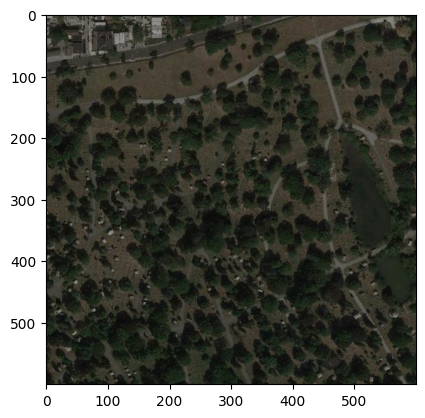

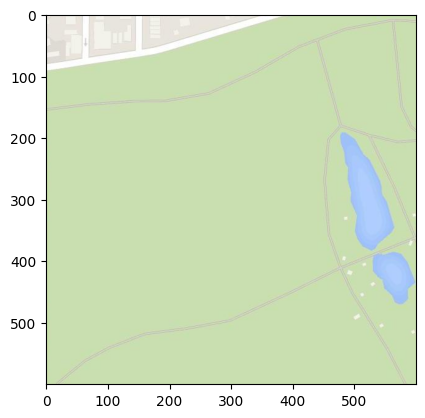

In [9]:
def split_data(root_dir):
  for i, img in enumerate(os.listdir(root_dir)):

    if img.endswith(".jpg"):
        img_path = os.path.join(root_dir, img)
        img = np.array(Image.open(img_path))
        # print(img.shape)

        input_img = img[:, :600, :]
        target_img = img[:, 600:, :]

        # show the output of spliting images
        if i == len(os.listdir(root_dir))-1:
          plt.imshow(input_img)
          plt.show()
          plt.imshow(target_img)
          plt.show()

split_data(train_data)

# Dataset

In [10]:
class MapDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.list_files = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        image = np.array(Image.open(img_path))

        # Split image into input and target
        input_image = image[:, :600, :]
        target_image = image[:, 600:, :]

        # Transformations
        transform_input = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((image_size, image_size), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])

        transform_target = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((image_size, image_size), Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])

        input_image = transform_input(input_image)
        target_image = transform_target(target_image)

        return input_image, target_image

# Test Dataset

In [11]:
dataset = MapDataset(train_data)
loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

input_img, target_img = next(iter(loader))
print(input_img.shape)
print(target_img.shape)

torch.Size([8, 3, 256, 256])
torch.Size([8, 3, 256, 256])


In [19]:
dis = Discriminator(in_channels=3).to(device)
gen = Generator(in_channels=3).to(device)
opt_dis = torch.optim.Adam(dis.parameters(), lr=lr, betas=(0.5, 0.999))
opt_gen = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))

loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

train_dataset = MapDataset(root_dir=train_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_dataset = MapDataset(root_dir=val_data)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# dis_scaler = torch.amp.GradScaler()
# gen_scaler = torch.amp.GradScaler()
dis_scaler = torch.cuda.amp.GradScaler()
gen_scaler = torch.cuda.amp.GradScaler()

/tmp/ipython-input-1881181325.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  dis_scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-1881181325.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  gen_scaler = torch.cuda.amp.GradScaler()


In [24]:
def save_some_examples(gen, val_loader, epoch, folder):
  x, y = next(iter(val_loader))
  x, y = x.to(device), y.to(device)
  gen.eval()
  with torch.no_grad():
    y_fake = gen(x)
    y_fake = y_fake * 0.5 + 0.5
    save_image(y_fake, folder + f"/y_gen_{epoch}.png")
    save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
    if epoch == 1:
      save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
  gen.train()

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
  print("=> Saving checkpoint")
  checkpoint = {
      "state_dict": model.state_dict(),
      "optimizer": optimizer.state_dict()
  }
  torch.save(checkpoint, filename)

os.makedirs("eval", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

In [26]:
def train_function(dis, gen, loader, opt_dis, opt_gen, loss, l1_loss, dis_scaler, gen_scaler):
  loop = tqdm(loader, leave=True)

  for idx, (x, y) in enumerate(loop):
    x = x.to(device)
    y = y.to(device)

    # Train Discriminator
    with torch.cuda.amp.autocast():
      y_fake = gen(x)
      dis_real = dis(x, y)
      dis_fake = dis(x, y_fake.detach())

      dis_real_loss = loss(dis_real, torch.ones_like(dis_real))
      dis_fake_loss = loss(dis_fake, torch.zeros_like(dis_fake))
      dis_loss = (dis_real_loss + dis_fake_loss) / 2

    dis.zero_grad()
    dis_scaler.scale(dis_loss).backward()
    dis_scaler.step(opt_dis)
    dis_scaler.update()

    # Train Generator
    with torch.cuda.amp.autocast():
      dis_fake = dis(x, y_fake)
      gen_fake_loss = loss(dis_fake, torch.ones_like(dis_fake))
      l1 = l1_loss(y_fake, y) * l1_lamba
      gen_loss = gen_fake_loss + l1

    opt_gen.zero_grad()
    gen_scaler.scale(gen_loss).backward()
    gen_scaler.step(opt_gen)
    gen_scaler.update()


for epoch in range(num_epochs):
  train_function(dis, gen, train_loader, opt_dis, opt_gen, loss, l1_loss, dis_scaler, gen_scaler)

  if epoch % 5 == 0:
    save_checkpoint(gen, opt_gen, filename=f"checkpoints/gen_{epoch}.pth.tar")
    save_checkpoint(dis, opt_dis, filename=f"checkpoints/dis_{epoch}.pth.tar")

  save_some_examples(gen, val_loader, epoch, folder="eval")

  0%|          | 0/137 [00:00<?, ?it/s]/tmp/ipython-input-2589278736.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-2589278736.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 137/137 [00:33<00:00,  4.12it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 137/137 [00:33<00:00,  4.06it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 137/137 [00:32<00:00,  4.23it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 137/137 [00:31<00:00,  4.29it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 137/137 [00:32<00:00,  4.23it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 137/137 [00:34<00:00,  4.02it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 137/137 [00:33<00:00,  4.09it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 137/137 [00:33<00:00,  4.06it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 137/137 [00:32<00:00,  4.24it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 137/137 [00:32<00:00,  4.20it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 137/137 [00:33<00:00,  4.03it/s]


# Show the results

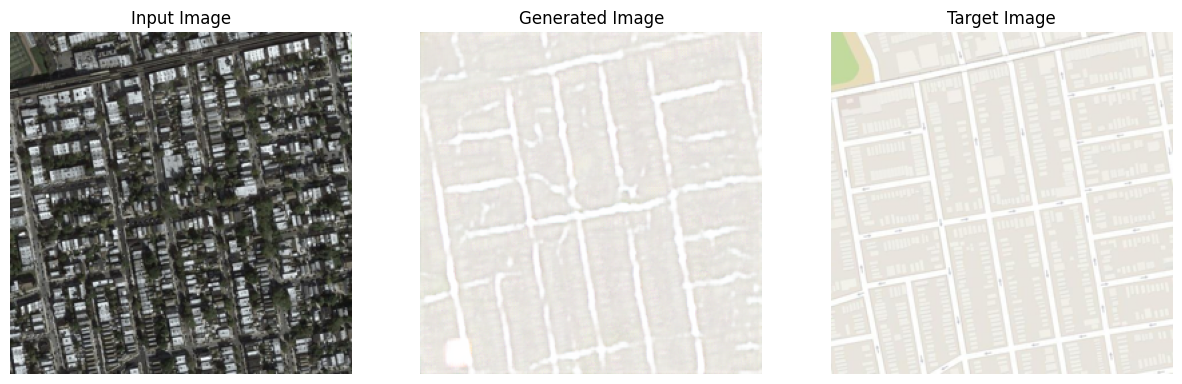

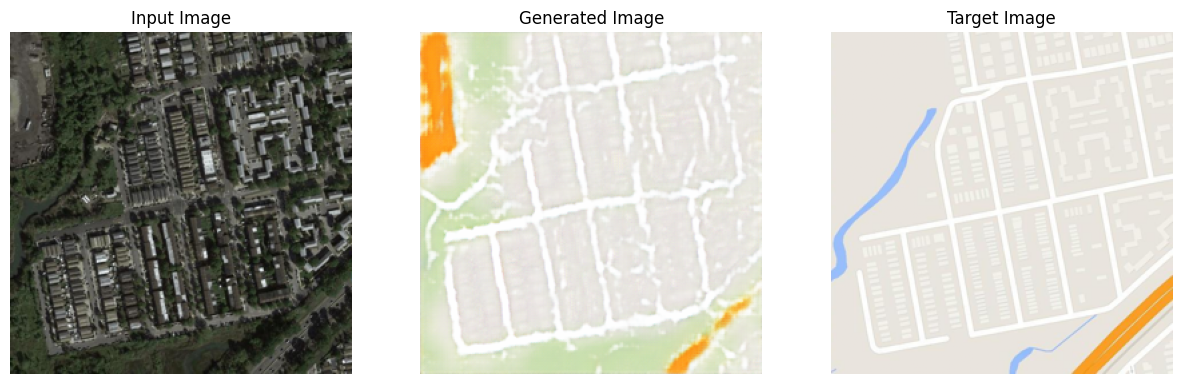

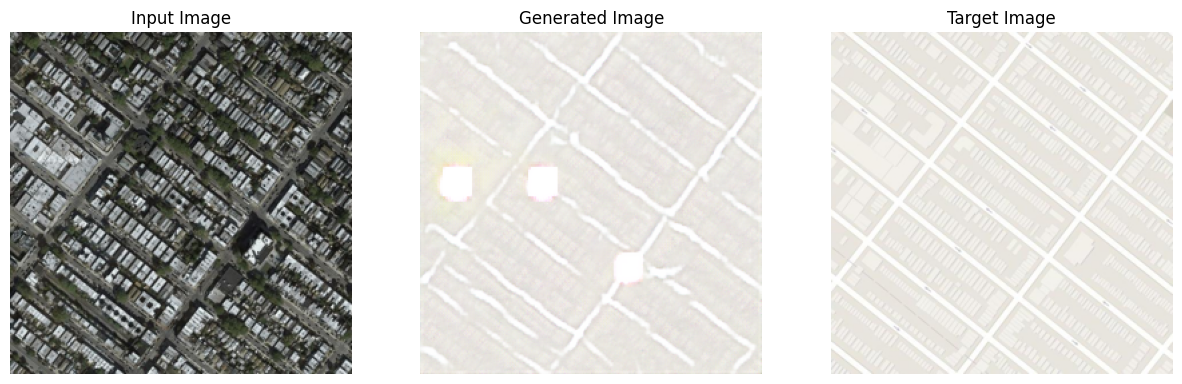

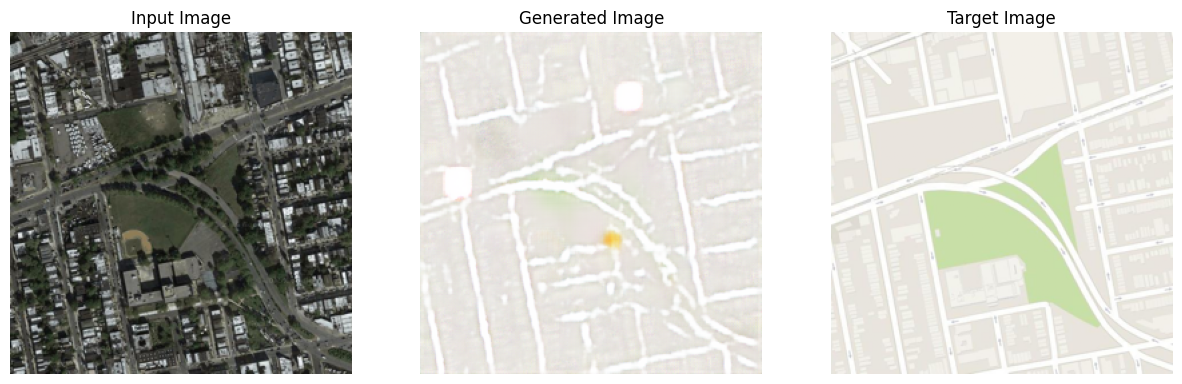

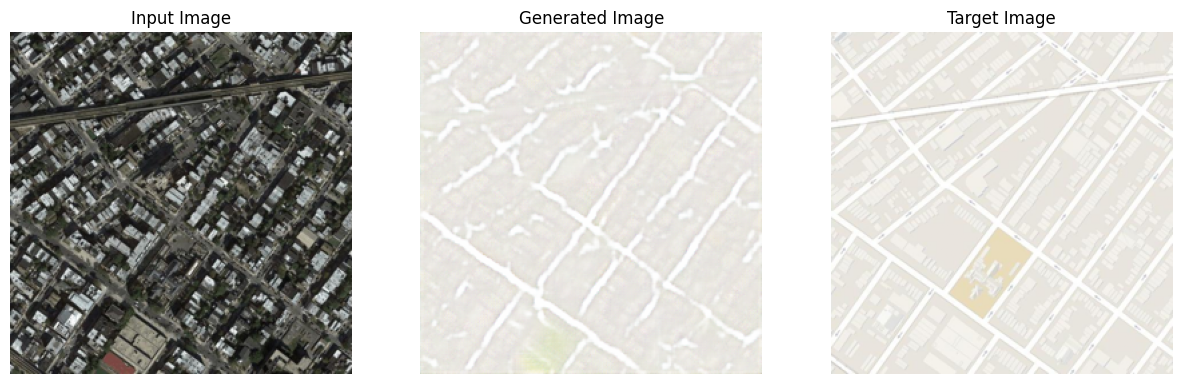

Testing complete. Generated images are displayed.


In [29]:
def test_model(gen, val_loader, device, folder="eval"):
    gen.eval()  # Set the generator to evaluation mode

    with torch.no_grad():
        for i, (x, y) in enumerate(val_loader):
            if i >= 5: # Stop after processing 5 images
                break
            x = x.to(device)
            y = y.to(device)

            y_fake = gen(x)

            # Denormalize images for displaying
            x_input_display = x[0].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5
            y_fake_display = y_fake[0].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5
            y_target_display = y[0].cpu().numpy().transpose(1, 2, 0) * 0.5 + 0.5

            # Display the input, generated, and target images
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(x_input_display)
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(y_fake_display)
            plt.title("Generated Image")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(y_target_display)
            plt.title("Target Image")
            plt.axis("off")

            plt.show()

    gen.train() # Set the generator back to training mode

# Load the trained generator model
checkpoint_path = "checkpoints/gen_45.pth.tar"
checkpoint = torch.load(checkpoint_path, map_location=device)
gen.load_state_dict(checkpoint["state_dict"])

# Call the test function
test_model(gen, val_loader, device)

print("Testing complete. Generated images are displayed.")